In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates 
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import statsmodels.formula.api as smf
import pyfixest as pf
# from linearmodels.iv import IV2SLS
# from linearmodels.iv.absorbing import AbsorbingLS

pd.set_option('display.max_columns', 100)
style.use("fivethirtyeight")



# Load out cleaned file with prices from previous stage

In [14]:
df = pd.read_csv('./0913/prozorro_scu_data_cpv3019.csv',sep=',')
print(df.shape)
df[:5]

(80739, 8)


,lot_id,product_description_ukr,price_vat,price_vat_norm,price_vat_log,Cluster,count_cluster,shapiro
0,UA-2023-01-02-000692-a-L1,Папір офісний Ф4,268.8,1.248773,5.593968,папір-10,2197,0.98616
1,UA-2023-01-03-003424-a-L1,Папір офісний формату А4,221.7,0.163516,5.401325,папір-10,2197,0.98616
2,UA-2023-01-04-001149-a-L1,Папір офісний А4,292.8,1.801770,5.679490,папір-10,2197,0.98616
3,UA-2023-01-11-008465-a-L1,Папір офісний А4,230.4,0.363978,5.439817,папір-10,2197,0.98616
4,UA-2023-01-11-008492-a-L1,Папір офісний А4,272.4,1.331722,5.607272,папір-10,2197,0.98616


# Load main prozorro (and potentially other) data

We download and add to our pricing dataset other data from Prozoro or we can add any other open data in Ukraine (for example, what is the gender of the authorized person/official who organized this particular purchase?).

Now I will just add information about the number of participants, the savings (the difference between the expected cost and the contract amount) and whether it is a purchase by Ukrposhta (the Ukrainian state-owned national postal operator)

In [15]:
df2 = pd.read_csv('0913/all_prozrorro_data_cpv0913.csv', sep=';')
df2 = df2[1:]

df2 = df2.rename(columns={
"Ідентифікатор лота":"lot_id",
"Клас CPV предмета лота":"cpv class",
"Назва предмета лота":"product description ukr",
"Очікувана кількість одиниць предмета лота":"count product in lot",
"Ціна за од":"price_vat",
"Кластер":"Cluster",
"Кількість товарів у кластері":"count_cluster",
"стд":"std",
"шапіро":"shapiro",
"Дата":"date",
"Кількість вимог лота":"Number of lot requirements",
"Кількість дискваліфікацій лота":"Number of lot disqualifications",
"Кількість звернень до органу моніторингу":"The number of appeals to the monitoring body",
"Тип методу закупівлі":"Type of procurement method",
"Кількість змін договорів лота":"The number of lot contract changes",
"Кількість моніторингів у закупівлі лота":"The number of monitorings in the purchase of the lot",
"Кількість моніторингів із знайденим порушенням у закупівлі лота":"The number of monitorings with a violation found in the purchase of the lot",
"Кількість питань лота":"Lot number of questions",
"Кількість скарг лота":"Lot number of complaints",
"Кількість учасників лота":"number_lot_participants",
"Сума лота":"lot_amount",
"Сума переможної пропозиції":"The amount of the winning bid",
"Вимагається гарантія забезпечення лота":"Lot security guarantee is required",
"Сума гарантії забезпечення":"The amount of the security guarantee",
"Чи надійшла учаснику вимога про усунення невідповідностей в пропозиції (24 години)":"Has the participant received a request to eliminate inconsistencies in the offer (24 hours)",
"Чи було зафіксовано аномально низьку ціну в пропозиції учасника (АНЦ)":"Was an abnormally low price recorded in the offer of the participant (ANC)",
"Код постачальника":"Supplier code",
"Постачальник":"Supplier",
"Регіон постачальника":"Supplier region",
"%экономииЛота":"lot_savings",
"Код організатора":"Organizer code",
"Організатор":"Organizer",
"Головний орган":"The main body",
"Регіон організатора":"Region of the organizer",
"Період оплати (днів)":"Payment period (days)",
"Чи передбачена передоплата":"Is prepayment provided?",
"К-сть змін одного файла ТД (максимальна)":"Number of changes to one TD file (maximum)",
"Подія оплати":"Payment event",
"Чи замасковано дані про очікувану вартість лота":"Is the data about the expected value of the lot masked?",
"Чи замасковано дані про учасника лота":"Is the data about the participant of the lot masked?",
"Чи надав учасник обгрунтування аномально низької ціни (АНЦ)":"Did the bidder provide justification for the abnormally low price (ANC)",
# "Чи став переможцем учасник після отримання вимоги про усунення невідповідностей в документації":"Did the participant become the winner after receiving a request to eliminate inconsistencies in the documentation",
# "Чи став переможцем учасник після отримання повідомлення про аномально низьку ціну (АНЦ)":"Did the participant become a winner after receiving a message about an abnormally low price (ANC)",
"ШагУменьшенияЛот":"StepReductionLot",
"Є в чорному списку АМКУ":"It is on the AMKU blacklist",
"Є конфіденційні файли у пропозиції":"There are confidential files in the offer",
"Є нецінові критерії":"There are non-price criteria",
"Є оскарження висновку органу моніторингу замовником у суді у закупівлі лота":"There is an appeal of the conclusion of the monitoring body by the customer in court regarding the purchase of the lot",
"Є порушення, виявлені органом моніторингу у закупівлі лота":"There are violations detected by the monitoring body in the purchase of the lot",
"Є файли ТД":"There are TD files",
"Різниця між очікуваною вартістю та переможною пропозицією":"The difference between the expected value and the winning bid",
"Джерела фінансування закупівлі":"Sources of funding for the purchase",
"Статус договорів лота":"Lot contract status",
"Причина розірвання договорів":"The reason for terminating the lot contract",
"Назва Учасника | Код Учасника":"Participant's name | Participant code",
'Конкурентність':'Competitiveness',
'Очікувана вартість':'expv',
'Клас CPV лота (агреговано)':'cpv'
# "Сумма 1 раунда":"Amount of 1 round",
# "Сумма 2 раунда":"Amount of 2 round",
# "Сумма 3 раунда":"Amount of 3 round"
})


df2['expv'] = pd.to_numeric(df2['expv'].str.replace(',','.').replace('\s+',''))
df2['date'] = pd.to_datetime(df2['date'],format='%d.%m.%Y')
df2['ukrposhta'] = df2['Organizer'].apply(lambda x: 1 if x=='АКЦІОНЕРНЕ ТОВАРИСТВО "УКРПОШТА"' else 0)

df = pd.merge(df,df2[['lot_id','date','Organizer','Competitiveness','number_lot_participants','lot_savings','expv','ukrposhta']],
               how='left',on='lot_id')
print(df.shape)

df[:3]

(80993, 15)


,lot_id,product_description_ukr,price_vat,price_vat_norm,price_vat_log,Cluster,count_cluster,shapiro,date,Organizer,Competitiveness,number_lot_participants,lot_savings,expv,ukrposhta
0,UA-2023-01-02-000692-a-L1,Папір офісний Ф4,268.8,1.248773,5.593968,папір-10,2197,0.98616,2023-01-02,Управління соціального захисту населення Мукач...,Неконкурентні,1.0,0.0,11200.0,0
1,UA-2023-01-03-003424-a-L1,Папір офісний формату А4,221.7,0.163516,5.401325,папір-10,2197,0.98616,2023-01-03,КОМУНАЛЬНЕ ПІДПРИЄМСТВО «НІКОПОЛЬСЬКЕ ВИРОБНИЧ...,Конкурентні,2.0,17.0,71928.0,0
2,UA-2023-01-04-001149-a-L1,Папір офісний А4,292.8,1.801770,5.679490,папір-10,2197,0.98616,2023-01-04,Золотоніська районна державна адміністрація Че...,Неконкурентні,1.0,0.0,51240.0,0


# Anilize

let's quickly check how the price depends on competition, the number of participants, and whether the best buyer of the Ukrposhta warehouse conducts purchases. 

Everything as we would expect. Competitive bidding has a lower price, each additional participant leads to a lower price, and Ukrposhta has the lowest prices in paper purchases (this is comparable to their own press releases)

In [16]:
df.groupby(['Competitiveness'])['price_vat_log'].mean()

Competitiveness
Конкурентні      3.436152
Неконкурентні    4.162453
Name: price_vat_log, dtype: float64

In [17]:
df[df['Cluster']=='папір-4'].groupby(['number_lot_participants'])['price_vat_log'].mean()

number_lot_participants
1.0    5.408039
2.0    5.083561
3.0    5.037711
4.0    5.000428
5.0    4.915354
6.0    4.975389
7.0    5.054042
8.0    4.943415
9.0    4.850467
Name: price_vat_log, dtype: float64

<Axes: title={'center': 'Ukrposhta = red circles'}, xlabel='date', ylabel='price_vat_norm'>

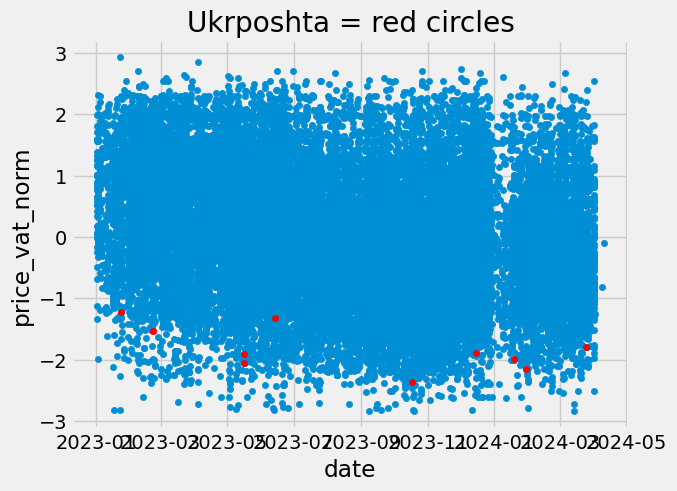

In [32]:
ax = df[(df['Cluster'].str.contains('папір'))].plot.scatter(x='date',y='price_vat_norm')
df[(df['ukrposhta']==1)].plot.scatter(x='date',y='price_vat_norm',color='red',ax=ax, rot=0, title='Ukrposhta = red circles')

and do some regression

In [31]:
fit1 = pf.feols("price_vat_log ~ Competitiveness|Cluster", data=df, vcov="HC1")
fit1.summary()


###

Estimation:  OLS
Dep. var.: price_vat_log, Fixed effects: Cluster
Inference:  HC1
Observations:  80993

| Coefficient                      |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:---------------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Competitiveness[T.Неконкурентні] |      0.512 |        0.008 |    67.969 |      0.000 |  0.497 |   0.526 |
---
RMSE: 0.377 R2: 0.931 R2 Within: 0.087 


###

Estimation:  OLS
Dep. var.: price_vat_log, Fixed effects: Cluster
Inference:  CRV1
Observations:  80993

| Coefficient             |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| number_lot_participants |     -0.138 |        0.016 |    -8.624 |      0.000 | -0.169 |  -0.106 |
---
RMSE: 0.383 R2: 0.929 R2 Within: 0.06 
###

Estimation:  OLS
Dep. var.: price_vat_log, Fixed effects: Cluster
Inference:  hetero
Observations:  80993

| Coefficient             |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:------------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| number_lot_participants |     -0.138 |        0.003 |   -51.373 |      0.000 | -0.143 |  -0.133 |
---
RMSE: 0.383 R2: 0.929 R2 Within: 0.06 


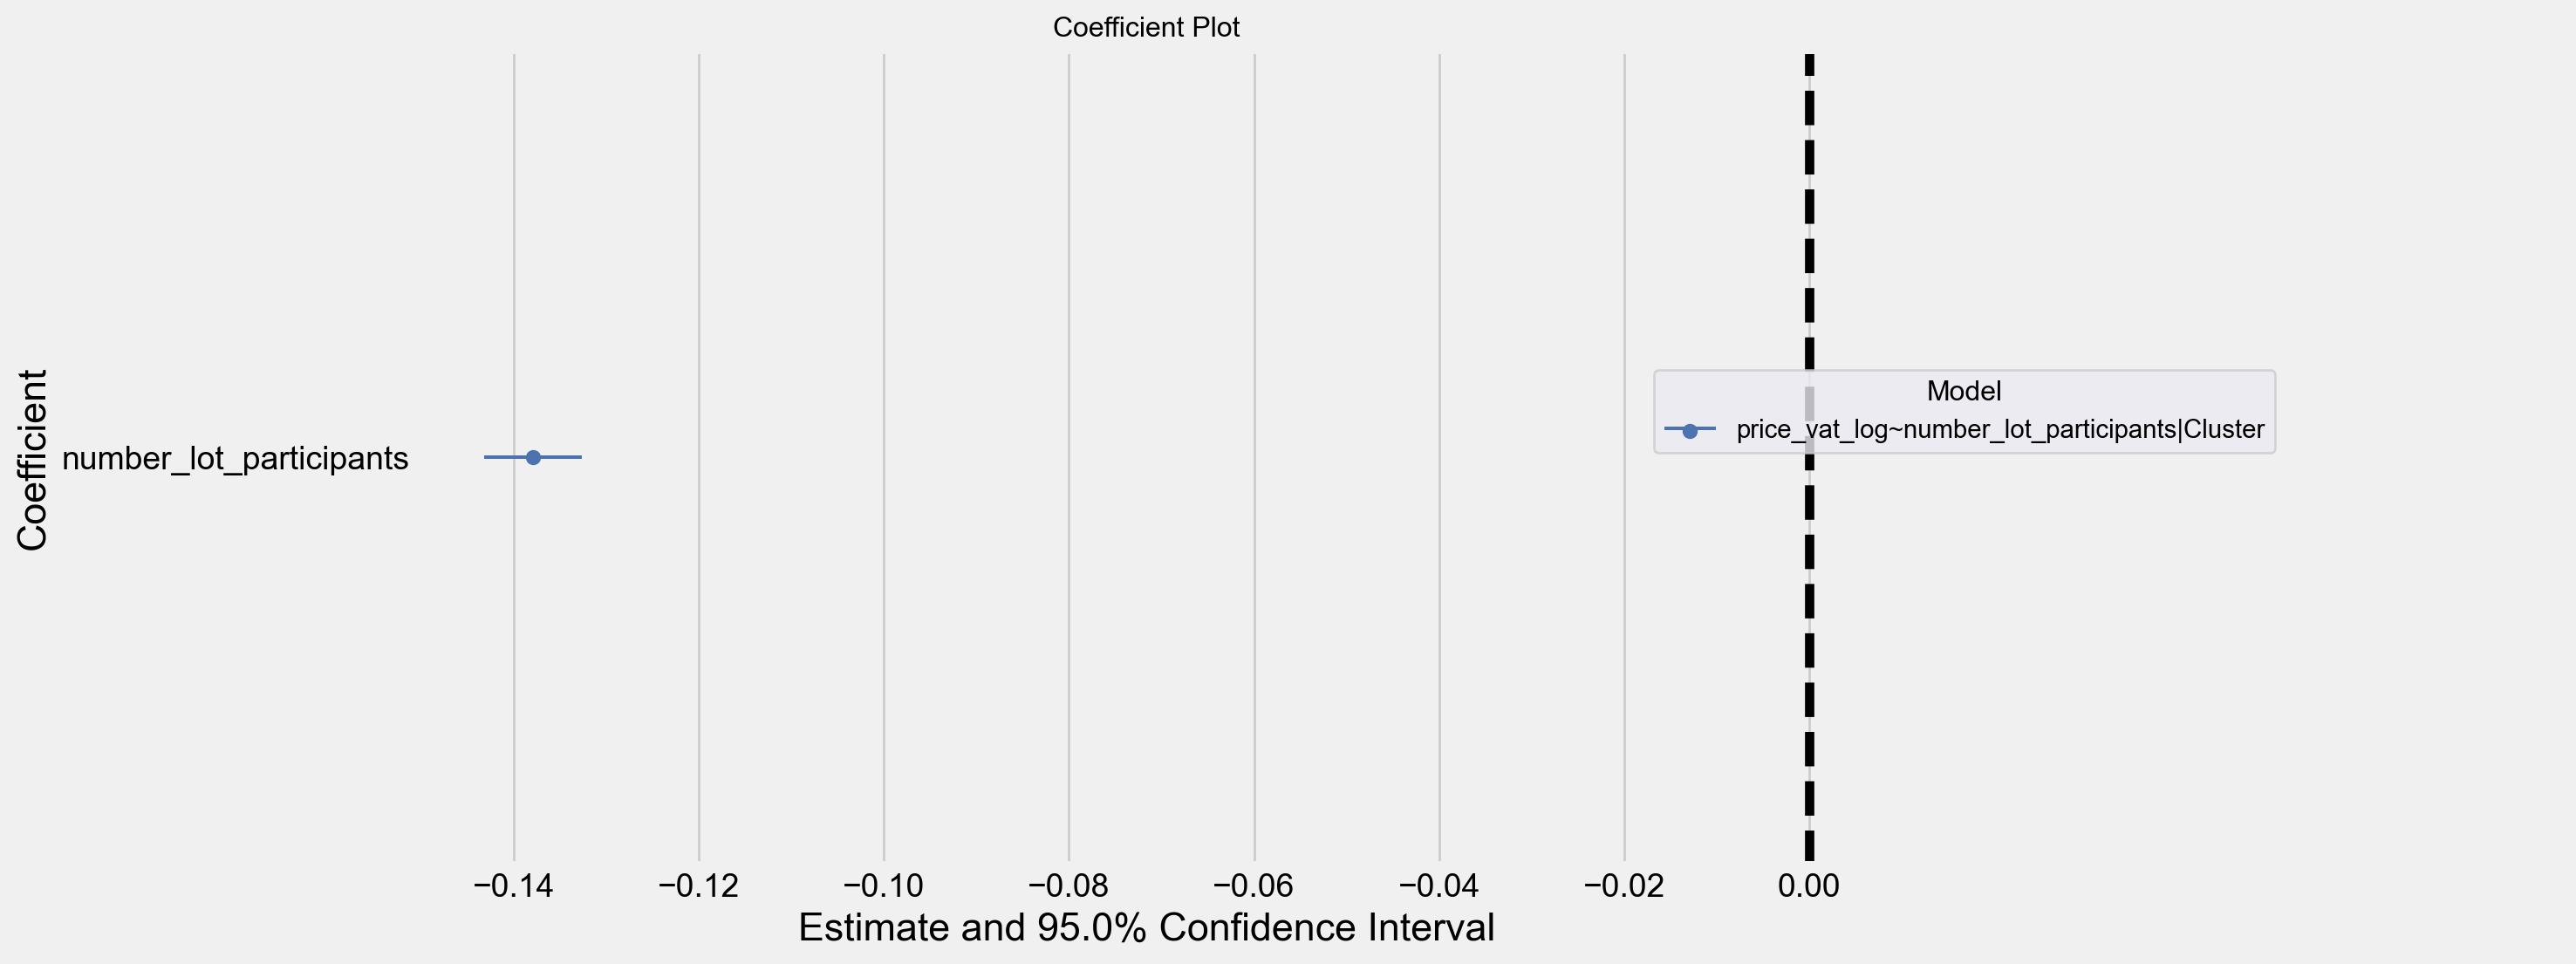

In [34]:
fit1 = pf.feols("price_vat_log ~ number_lot_participants|Cluster", data=df)
fit1.summary()
fit1.vcov("hetero").summary()
fit1.coefplot(plot_backend="matplotlib")

In [11]:
print('Each additional member is associated with a', round((1-np.exp(fit1.coef()['number_lot_participants']))*100),'% lower price')

Each additional member is associated with a 13 % lower price
